# Chapter 15: Comparing means

In [1]:
library(tidyverse)
library(ggplot2)
library(tidyr)
library(fivethirtyeight)
library(BayesFactor)
library(lme4)
library(lmerTest)
library(cowplot)
library(knitr)
library(emmeans)
theme_set(theme_minimal(base_size = 14))

set.seed(123456) # set random seed to exactly replicate results

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <-
  NHANES %>%
  subset(Age>=18) %>%
  drop_na(BMI)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Some larger datasets need to be installed separately, like senators and
house_district_forecast. To install these, we recommend you install the
fivethirtyeightdata package by running:
install.packages('fivethirtyeightdata', repos =
'https://fivethirtyeightdata.github.io/drat/', type = 'source')

Loading required package: coda

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManua

## Binomial test for a single proportion

In [2]:
NHANES_sample <-
  NHANES_adult %>%
  drop_na(BPDiaAve) %>%
  mutate(Hypertensive = BPDiaAve > 80) %>%
  sample_n(200)

# compute sign test for differences between first and second measurement
npos <- sum(NHANES_sample$Hypertensive)
bt <- binom.test(npos, nrow(NHANES_sample), alternative='greater')
bt


	Exact binomial test

data:  npos and nrow(NHANES_sample)
number of successes = 38, number of trials = 200, p-value = 1
alternative hypothesis: true probability of success is greater than 0.5
95 percent confidence interval:
 0.1455539 1.0000000
sample estimates:
probability of success 
                  0.19 


## T-test output

In [3]:
tt = t.test(x=NHANES_adult$BPDiaAve, mu=80, alternative='greater')
tt


	One Sample t-test

data:  NHANES_adult$BPDiaAve
t = -55.265, df = 4593, p-value = 1
alternative hypothesis: true mean is greater than 80
95 percent confidence interval:
 69.1928     Inf
sample estimates:
mean of x 
 69.50522 


## Bayes factor output

In [4]:
ttestBF(NHANES_sample$BPDiaAve, mu=80, nullInterval=c(-Inf, 80))

t is large; approximation invoked.

t is large; approximation invoked.



Bayes factor analysis
--------------
[1] Alt., r=0.707 -Inf<d<80    : 2.732736e+16 ±NA%
[2] Alt., r=0.707 !(-Inf<d<80) : NaNe-Inf     ±NA%

Against denominator:
  Null, mu = 80 
---
Bayes factor type: BFoneSample, JZS


## Figure 15.1

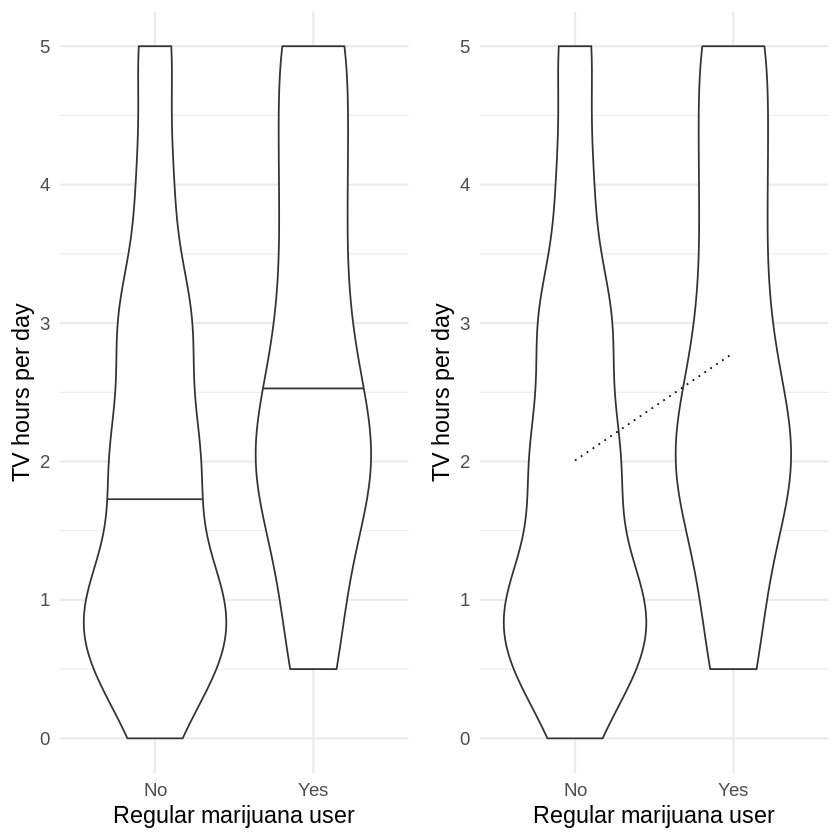

In [6]:
# create sample with tv watching and marijuana use

NHANES_sample <-
  NHANES_adult %>%
  drop_na(TVHrsDay, RegularMarij) %>%
  mutate(
    TVHrsNum = recode( #recode character values into numerical values
      TVHrsDay,
      "More_4_hr" = 5,
      "4_hr" = 4,
      "2_hr" = 2,
      "1_hr" = 1,
      "3_hr" = 3,
      "0_to_1_hr" = 0.5,
      "0_hrs" = 0
    )
  ) %>%
  sample_n(200)

lm_summary <- summary(lm(TVHrsNum ~ RegularMarij, data = NHANES_sample))

p1 <- ggplot(NHANES_sample,aes(RegularMarij,TVHrsNum)) +
  geom_violin(draw_quantiles=.50) +
  labs(
    x = "Regular marijuana user",
    y = "TV hours per day"
  )

p2 <- ggplot(NHANES_sample,aes(RegularMarij,TVHrsNum)) +
  geom_violin() +
  annotate('segment',x=1,y=lm_summary$coefficients[1,1],
           xend=2,
           yend=lm_summary$coefficients[1,1]+lm_summary$coefficients[2,1],
           linetype='dotted') +
  labs(
    x = "Regular marijuana user",
    y = "TV hours per day"
  )

plot_grid(p1, p2)

## T-test result

In [ ]:

ttresult <- t.test(
  TVHrsNum ~ RegularMarij,
  data = NHANES_sample,
  alternative = 'less'
)

ttresult

## Linear model summary

In [7]:
# print summary of linear regression to perform t-test
lm_summary


Call:
lm(formula = TVHrsNum ~ RegularMarij, data = NHANES_sample)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.28431 -1.00671 -0.00671  0.99329  2.99329 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.0067     0.1162   17.27  < 2e-16 ***
RegularMarijYes   0.7776     0.2300    3.38 0.000872 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.418 on 198 degrees of freedom
Multiple R-squared:  0.05456,	Adjusted R-squared:  0.04978 
F-statistic: 11.43 on 1 and 198 DF,  p-value: 0.0008724


## Bayes factor for mean differences

In [ ]:
# compute bayes factor for group comparison
# In this case, we want to specifically test against the null hypothesis that the difference is greater than zero - because the difference is computed by the function between the first group ('No') and the second group ('Yes'). Thus, we specify a "null interval" going from zero to infinity, which means that the alternative is less than zero.
bf <- ttestBF(
  formula = TVHrsNum ~ RegularMarij,
  data = NHANES_sample,
  nullInterval = c(0, Inf)
)
bf

## Figure 15.2

In [ ]:
set.seed(12345678)

NHANES_sample <-
  NHANES %>%
  dplyr::filter(Age>17 & !is.na(BPSys2) & !is.na(BPSys1)) %>%
  dplyr::select(BPSys1,BPSys2,ID) %>%
  sample_n(200)

NHANES_sample_tidy <-
  NHANES_sample %>%
  gather(timepoint,BPsys,-ID)

NHANES_sample <-
  NHANES_sample %>%
  mutate(
    diff=BPSys1-BPSys2,
    diffPos=as.integer(diff>0),
    meanBP=(BPSys1+BPSys2)/2
  )

p1 <- ggplot(NHANES_sample_tidy,aes(timepoint,BPsys)) +
  geom_violin() +
  scale_x_discrete(
    labels = c("Time 1", "Time 2"),
  )
p2 <- p1 +geom_line(aes(group=ID))

plot_grid(p1, p2)

## T-test output

In [ ]:
t.test(
  BPsys ~ timepoint,
  data = NHANES_sample_tidy,
  paired = FALSE,
  var.equal = TRUE
)

## Figure 15.3

In [ ]:
ggplot(NHANES_sample,aes(diff)) +
  geom_histogram(bins=30) +
  geom_vline(xintercept = mean(NHANES_sample$diff),color='blue')

## Sign test


In [ ]:
# compute sign test for differences between first and second measurement
npos <- sum(NHANES_sample$diffPos)
bt <- binom.test(npos, nrow(NHANES_sample))
bt

## Paired t-test


In [ ]:
# compute paired t-test
t.test(BPsys ~ timepoint, data = NHANES_sample_tidy, paired = TRUE)

## Bayes factor result

In [ ]:
# compute Bayes factor for paired t-test
ttestBF(x = NHANES_sample$BPSys1, y = NHANES_sample$BPSys2, paired = TRUE)

## Figure 15.4

In [ ]:
set.seed(123456)

nPerGroup <- 36
noiseSD <- 10
meanSysBP <- 140
effectSize <- 0.8
df <- data.frame(
  group=as.factor(c(rep('placebo',nPerGroup),
                    rep('drug1',nPerGroup),
                    rep('drug2',nPerGroup))),
  sysBP=NA)

df$sysBP[df$group=='placebo'] <- rnorm(nPerGroup,mean=meanSysBP,sd=noiseSD)
df$sysBP[df$group=='drug1'] <- rnorm(nPerGroup,mean=meanSysBP-noiseSD*effectSize,sd=noiseSD)
df$sysBP[df$group=='drug2'] <- rnorm(nPerGroup,mean=meanSysBP,sd=noiseSD)

ggplot(df,aes(group,sysBP)) + geom_boxplot() + ylab('systolic blood pressure')

## Figure 15.5

In [ ]:
fdata <-
  data.frame(x=seq(0.1,10,.1)) %>%
  mutate(
    f_1_1=df(x,1,1),
    f_1_50=df(x,1,50),
    f_10_50=df(x,10,50)
  )

ggplot(fdata,aes(x,f_1_1)) +
  geom_line() +
  geom_line(aes(x,f_1_50),linetype='dotted') +
  geom_line(aes(x,f_10_50),linetype='dashed') +
  labs(y = "Density", x = "F values")

## ANOVA result

In [ ]:
# create dummy variables for drug1 and drug2
df <-
  df %>%
  mutate(
    d1 = as.integer(group == "drug1"), # 1s for drug1, 0s for all other drugs
    d2 = as.integer(group == "drug2")  # 1s for drug2, 0s for all other drugs
  )

# test model without separate duymmies
lmResultAnovaBasic <- lm(sysBP ~ group, data=df)
emm.result <- emmeans(lmResultAnovaBasic, "group" )
# pairs(emm.result)

# fit ANOVA model
lmResultANOVA <- lm(sysBP ~ d1 + d2, data = df)
summary(lmResultANOVA)